## Simpsons Image Classification.

### 0. Initial Variables

In [1]:
from google.colab import auth
from googleapiclient.discovery import build


# The dataset to download from Kaggle
KAGGLE_DATASET = "alexattia/the-simpsons-characters-dataset"

# The directory where the dataset is extracted
KAGGLE_UNZIP_DATASET_DIR = "/content/simpsons_data"

# The Google Drive Folder ID to read / write files
GOOGLE_DRIVE_FOLDER_ID = "1GZ0NBMKvCcNAvPdW50j6OwcSasaoK8A1"

# Source Dataset Directory
SOURCE_DATASET = f"{KAGGLE_UNZIP_DATASET_DIR}/simpsons_dataset"

# The pre processed dataset with labels
PRE_PROCESSED_DATASET = "simpsons_pre_processed_data.npz"

# The train dataset
TRAIN_DATASET = "simpsons_train_data.npz"

# The train dataset
VAL_DATASET = "simpsons_val_data.npz"

# The test dataset
TEST_DATASET = "simpsons_test_data.npz"

# The Image Size (width,height)
IMG_WIDTH = 128
IMG_HEIGHT = 128

# Request permissions to access (read/write) the Google Drive Folder ID
auth.authenticate_user()
drive_service = build('drive', 'v3')

print(f"Successful initialization: Dataset: {KAGGLE_DATASET} - Google Drive Id: {GOOGLE_DRIVE_FOLDER_ID}")

Successful initialization: Dataset: alexattia/the-simpsons-characters-dataset - Google Drive Id: 1GZ0NBMKvCcNAvPdW50j6OwcSasaoK8A1


In [2]:
from googleapiclient.http import MediaFileUpload

def save_dataset(fileName, X, y, class_names):
  np.savez_compressed(fileName, X=X, y=y, labels=class_names)

  file_metadata = {
      'name': fileName,
      'parents': [GOOGLE_DRIVE_FOLDER_ID]
  }
  media = MediaFileUpload(fileName, mimetype='application/octet-stream')

  file = drive_service.files().create(body=file_metadata, media_body=media, fields='id').execute()
  print(f"Dataset successfully '{fileName}' stored. ID in Drive: {file.get('id')}")


def load_dataset(folder_id, filename):
    query = f"name = '{filename}' and '{folder_id}' in parents and trashed = false"
    results = drive_service.files().list(q=query, fields="files(id, name)").execute()
    items = results.get('files', [])

    if not items:
        print(f"No found the file '{filename}' in the folder '{folder_id}'.")
        return None, None, None

    file_id = items[0]['id']
    request = drive_service.files().get_media(fileId=file_id)
    fh = io.BytesIO()
    downloader = MediaIoBaseDownload(fh, request)

    done = False
    while done is False:
        status, done = downloader.next_chunk()
        print(f"Download progress: {int(status.progress() * 100)}%")

    # Load NumPy data from the memory buffer
    fh.seek(0)
    data = np.load(fh, allow_pickle=True)

    X = data['X']
    y = data['y']
    labels = data['labels']

    print("Data successfully loaded.")
    return X, y, labels


def display_image(x_data, y_data, index, class_names=None):
    """
    Displays an image from the dataset with its numeric and text label.
    """
    img = x_data[index]
    label_raw = y_data[index]

    # 1. Handle One-Hot or Integer labels
    if hasattr(label_raw, '__len__') and len(label_raw) > 1:
        label_id = np.argmax(label_raw)
    else:
        label_id = int(np.array(label_raw).item())

    # 2. Setup Plot
    plt.figure(figsize=(5, 5))

    # If images were normalized (0-1 float), imshow handles it.
    # If they are 0-255 int, we ensure the type is uint8.
    if img.max() > 1.0 and img.dtype != np.uint8:
        img = img.astype(np.uint8)

    plt.imshow(img)

    # 3. Create Title (Numeric ID + Name)
    title = f"Index: {index} | Label ID: {label_id}"

    if class_names is not None:
        try:
            character_name = class_names[label_id]
            title += f"\nCharacter: {character_name.replace('_', ' ').title()}"
        except IndexError:
            title += "\n(Name not found in class_names)"

    plt.title(title)
    plt.axis('off')
    plt.show()

### 1. Download Dataset.

In [ ]:
import os
from google.colab import userdata

# Getting Kaggle credentials and setting in environment
os.environ['KAGGLE_USERNAME'] = userdata.get('KAGGLE_USERNAME')
os.environ['KAGGLE_KEY'] = userdata.get('KAGGLE_KEY')

# Download and unzip dataset from Kaggle
!kaggle datasets download -d {KAGGLE_DATASET}
!unzip -q the-simpsons-characters-dataset.zip -d {KAGGLE_UNZIP_DATASET_DIR}

print(f"Downloaded {KAGGLE_DATASET} in {KAGGLE_UNZIP_DATASET_DIR}")

Dataset URL: https://www.kaggle.com/datasets/alexattia/the-simpsons-characters-dataset
License(s): CC-BY-NC-SA-4.0
the-simpsons-characters-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
replace /content/simpsons_data/annotation.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
Downloaded alexattia/the-simpsons-characters-dataset in /content/simpsons_data


### 2. Prepare Dataset.

In [3]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

def load_simpsons_dataset_with_labels(directory, img_width, img_height):
    print("Loading datasets with labels may take a while")
    images = []
    labels = []
    class_names = sorted(os.listdir(directory))
    class_map = {name: i for i, name in enumerate(class_names)}

    # Browse folders
    for class_name in class_names:
        class_dir = os.path.join(directory, class_name)
        if not os.path.isdir(class_dir):
            continue

        class_idx = class_map[class_name]

        # Read images from each folder
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            try:
                # Read image with OpenCV
                img = cv2.imread(img_path)
                if img is not None:
                    # Convert BGR (OpenCV) to RGB
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    # Resize (CNN needs fixed size)
                    img = cv2.resize(img, (img_width, img_height))

                    images.append(img)
                    labels.append(class_idx)
            except Exception as e:
                print(f"Error loading {img_path}: {e}")

    # Convert to numpy arrays
    X = np.array(images)
    y = np.array(labels)

    # Mix data (Shuffle)
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]

    return X, y, class_names


X_full, y_full, class_names = load_simpsons_dataset_with_labels(SOURCE_DATASET, IMG_WIDTH, IMG_HEIGHT)
save_dataset(PRE_PROCESSED_DATASET, X_full, y_full, class_names)

print(f"# of samples: {len(X_full)}")
print(f"# of clases: {len(class_names)}: {class_names}")


Loading datasets with labels may take a while


Dataset successfully 'simpsons_pre_processed_data.npz' stored. ID in Drive: 1aXhoyV39vySY-kqo63yw4npzBrx-qAPO
# of samples: 20933
# of clases: 43: ['abraham_grampa_simpson', 'agnes_skinner', 'apu_nahasapeemapetilon', 'barney_gumble', 'bart_simpson', 'carl_carlson', 'charles_montgomery_burns', 'chief_wiggum', 'cletus_spuckler', 'comic_book_guy', 'disco_stu', 'edna_krabappel', 'fat_tony', 'gil', 'groundskeeper_willie', 'homer_simpson', 'kent_brockman', 'krusty_the_clown', 'lenny_leonard', 'lionel_hutz', 'lisa_simpson', 'maggie_simpson', 'marge_simpson', 'martin_prince', 'mayor_quimby', 'milhouse_van_houten', 'miss_hoover', 'moe_szyslak', 'ned_flanders', 'nelson_muntz', 'otto_mann', 'patty_bouvier', 'principal_skinner', 'professor_john_frink', 'rainier_wolfcastle', 'ralph_wiggum', 'selma_bouvier', 'sideshow_bob', 'sideshow_mel', 'simpsons_dataset', 'snake_jailbird', 'troy_mcclure', 'waylon_smithers']


### 3. Load Pre-processed Dataset from Google Drive

In [5]:
from google.colab import auth
from googleapiclient.discovery import build
from googleapiclient.http import MediaIoBaseDownload
import io
import numpy as np
import matplotlib.pyplot as plt


X_full, y_full, class_names = load_dataset(GOOGLE_DRIVE_FOLDER_ID, PRE_PROCESSED_DATASET)

print(f"# of samples: {len(X_full)}")
print(f"# of clases: {len(class_names)}: {class_names}")



Download progress: 21%
Download progress: 42%
Download progress: 63%
Download progress: 84%
Download progress: 100%
Data successfully loaded.
# of samples: 20933
# of clases: 43: ['abraham_grampa_simpson' 'agnes_skinner' 'apu_nahasapeemapetilon'
 'barney_gumble' 'bart_simpson' 'carl_carlson' 'charles_montgomery_burns'
 'chief_wiggum' 'cletus_spuckler' 'comic_book_guy' 'disco_stu'
 'edna_krabappel' 'fat_tony' 'gil' 'groundskeeper_willie' 'homer_simpson'
 'kent_brockman' 'krusty_the_clown' 'lenny_leonard' 'lionel_hutz'
 'lisa_simpson' 'maggie_simpson' 'marge_simpson' 'martin_prince'
 'mayor_quimby' 'milhouse_van_houten' 'miss_hoover' 'moe_szyslak'
 'ned_flanders' 'nelson_muntz' 'otto_mann' 'patty_bouvier'
 'principal_skinner' 'professor_john_frink' 'rainier_wolfcastle'
 'ralph_wiggum' 'selma_bouvier' 'sideshow_bob' 'sideshow_mel'
 'simpsons_dataset' 'snake_jailbird' 'troy_mcclure' 'waylon_smithers']


### Show random images

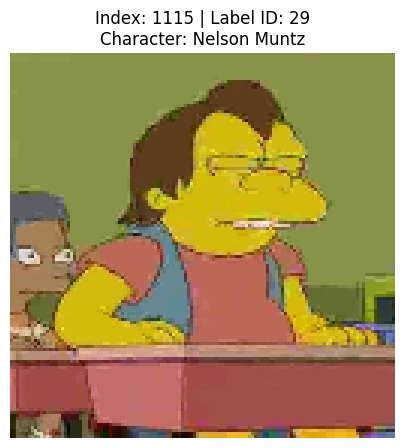

In [7]:

random_index = np.random.randint(0, len(X_full))
display_image(X_full, y_full, random_index, class_names)

### 4. Feature Engineering

In [23]:
import numpy as np
import os
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

class_names = np.unique(y_full)
num_classes = len(class_names)

# Normalize the data: rescale from [0,255] to [0,1]
X_full = X_full.astype('float32') / 255.0

# Label Encoding
y_full = to_categorical(y_full, num_classes)

# Train dataset and balancing classes
X_train, X_temp, y_train, y_temp = train_test_split(
    X_full,
    y_full,
    test_size=0.20,
    random_state=42,
    stratify=y_full  # This ensures class balancing.
)

# Then we divide that 20% in half to get 10% and 10%.
X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.50,
    random_state=42,
    stratify=y_temp # Balancing in the second split
)

IndexError: index 42 is out of bounds for axis 1 with size 42

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# 1. Data Normalization
# Convert to float32 and rescale from [0, 255] to [0, 1]
X_full = X_full.astype('float32') / 255.0

# 2. Label Encoding
le = LabelEncoder()
y_encoded = le.fit_transform(y_full)

# Class names and number of claseses
class_names = le.classes_
num_classes = len(class_names)

# 3. Label One-Hot Encoding
y_categorical = to_categorical(y_encoded, num_classes)

# 4. First Split: 80% Training and 20% Temporary (Validation + Test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_full,
    y_categorical,
    test_size=0.20,
    random_state=42,
    stratify=y_categorical  # Maintains the class ratio
)

# 5. Second Split: We divide the temporary 20% in half (10% Val, 10% Test)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.50,
    random_state=42,
    stratify=y_temp
)

# --- Verificación de resultados ---
print(f"Total de clases detectadas: {num_classes}")
print("-" * 30)
print(f"X_train shape: {X_train.shape} | y_train shape: {y_train.shape}")
print(f"X_val   shape: {X_val.shape}   | y_val   shape: {y_val.shape}")
print(f"X_test  shape: {X_test.shape}  | y_test  shape: {y_test.shape}")